# Demo

In [1]:
#| code-summary: code -- load dependencies and data and parametrize the evaluation
#| echo: false
#| output: false

from response_sequencer.datasets import SensesDataset, JSON_Dataset
from response_sequencer.evaluating import LevenshteinMatcherEvaluator, DatasetEvaluator, DatasetGenerator
from response_sequencer.sequencing import BaselineSequencer, BaselinePlusContextSequencer, BaselinePlusFragmentsSequencer, BaselinePlusContextPlusFragmentsSequencer

import os
import pandas as pd

section_tag = "Senses_Dataset"
results_path = "results/"
figures_path = "figures/"

figure_caption = """Performance"""

dataset = SensesDataset(
    os.path.join('../../data/', 'base_senses.h5'), 
    os.path.join('../../data/', 'base_sense_pool.txt'))

sequencers = {
    "Baseline": BaselineSequencer(), 
    "Baseline+\nContextualized\nEmbeddings": BaselinePlusContextSequencer(), 
    "Baseline+\nExhaustive\nSegmentation": BaselinePlusFragmentsSequencer(), 
    "Baseline+\nBoth": BaselinePlusContextPlusFragmentsSequencer()
}

metrics = {
    "Edit_Distance": LevenshteinMatcherEvaluator(only_matched=True)
}

sample_size = 0 # worth noting that 0 means all
randomize = False
only_matched = True

In [2]:
#| code-summary: generate performance data for each sequencer
#| echo: false
#| output: false

for sequencer_index, sequencer_name in enumerate(sequencers):

    # load sequencing results for this sequencer and section tag from json if they exist
    # otherwise, generate the sequencing results for this sequencer and section tag
    out_path = results_path + f'{section_tag}_{sequencer_name}.json'.replace('\n', '_').replace(' ', '_')
    if os.path.isfile(out_path):
        print(f'sequencing results for {sequencer_name} with tag {section_tag} already exist')
        continue
    else: 
        sequencer = sequencers[sequencer_name]
        DatasetGenerator()(dataset, sequencer, out_path=out_path, samples=sample_size, random=randomize)

sequencing results for Baseline with tag Senses_Dataset already exist
sequencing results for Baseline+
Contextualized
Embeddings with tag Senses_Dataset already exist
sequencing results for Baseline+
Exhaustive
Segmentation with tag Senses_Dataset already exist


100%|██████████| 2870/2870 [6:35:14<00:00,  8.26s/it]   


In [3]:
#| code-summary: build dataframe for each metric
#| echo: false
#| output: false

scores = {}
for metric_index, metric_name in enumerate(metrics):
    metric = metrics[metric_name]
    scores[metric_name] = {'Sequencer': [], 'score': []}

    for sequencer_index, sequencer_name in enumerate(sequencers):
        out_path = results_path + f'{section_tag}_{sequencer_name}.json'.replace('\n', '_').replace(' ', '_')
        generated_dataset = JSON_Dataset(out_path)
    
        dataset_evaluator = DatasetEvaluator(dataset, generated_dataset)

        result = dataset_evaluator(metric)
        scores[metric_name]['Sequencer'] += [sequencer_name] * len(result)
        scores[metric_name]['score'] += result

for metric_name in scores.keys():
    scores[metric_name] = pd.DataFrame(scores[metric_name])

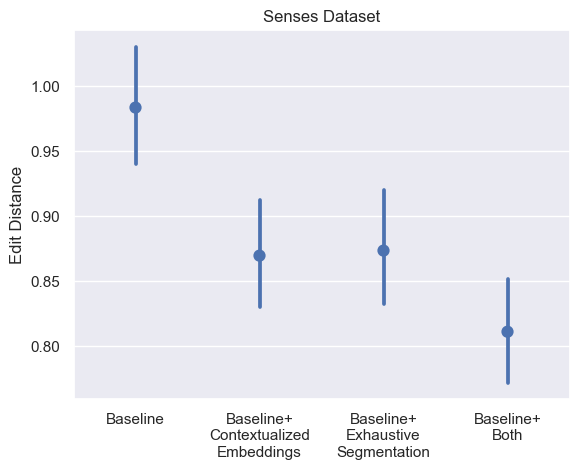

In [4]:
#|output: true
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

for metric_index, metric_name in enumerate(metrics):
    x = sns.pointplot(x="Sequencer", y="score", data=scores[metric_name], join=False)
    x.set_ylabel(metric_name.replace('_', ' '))
    x.set_xlabel('')
    x.set_title(section_tag.replace('_', ' '))

    plt.show()